# 4. Modeling

In this phase, we will fine-tune a pre-trained BERT model for our sentiment analysis task. We will use `vinai/bertweet-base`, a model specifically pre-trained on a large corpus of English tweets, making it highly suitable for this project.

### 4.1 Data Preparation

To make this notebook self-contained, we first need to load and prepare the data. This involves repeating the key steps from the `3_Data_Preparation` notebook: loading the sampled data, cleaning the text, splitting it into sets, tokenizing it for BERT, and creating PyTorch DataLoaders.

In [11]:
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import sys

# Define path
SAMPLED_DATA_PATH = Path('../data/sentiment140_sampled_200k.csv')

# --- Global Model and Device Setup ---
MODEL_NAME = 'vinai/bertweet-base'

# -- Hardware Check --
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found. Using Apple Silicon GPU.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found. Using NVIDIA GPU.")
else:
    device = torch.device("cpu")
    print("No GPU found. Using CPU.")

# ERROR HANDLING: Load the sampled dataset
if not SAMPLED_DATA_PATH.exists():
    print(f"❌ ERROR: Sampled dataset not found at {SAMPLED_DATA_PATH.absolute()}")
    print("Please run Notebook 3 (Data Preparation) first to create the sampled dataset")
    sys.exit(1)

try:
    df_sampled = pd.read_csv(SAMPLED_DATA_PATH)
    print(f"✓ Sampled dataset loaded: {df_sampled.shape}")
except Exception as e:
    print(f"❌ ERROR loading sampled dataset: {e}")
    sys.exit(1)

# --- Text Cleaning ---
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_sampled['cleaned_text'] = df_sampled['text'].apply(clean_tweet)

# --- Data Splitting ---
X = df_sampled['cleaned_text'].astype(str) # Ensure text is string
y = df_sampled['target'].apply(lambda x: 1 if x == 4 else 0) # Map target to 0 and 1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# --- Tokenization ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(X_test.tolist())

# --- PyTorch Datasets and DataLoaders ---
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, y_train.to_numpy())
val_dataset = TweetDataset(val_encodings, y_val.to_numpy())
test_dataset = TweetDataset(test_encodings, y_test.to_numpy())

# Optimize batch size and workers for Apple Silicon
if device.type == 'mps':
    # Larger batch sizes work well on M5 with unified memory
    train_batch_size = 32
    eval_batch_size = 64
    num_workers = 4  # Apple Silicon handles parallel loading well
    print("📱 Optimized for Apple Silicon: larger batches + parallel data loading")
elif device.type == 'cuda':
    train_batch_size = 16
    eval_batch_size = 32
    num_workers = 2
    print("🎮 Optimized for NVIDIA GPU")
else:
    train_batch_size = 8
    eval_batch_size = 16
    num_workers = 0
    print("💻 CPU mode: smaller batches")

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device.type=='cuda'))
val_loader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device.type=='cuda'))
test_loader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device.type=='cuda'))

print(f"Data preparation complete. Using batch_size={train_batch_size} for training.")

MPS device found. Using Apple Silicon GPU.
✓ Sampled dataset loaded: (200000, 6)
✓ Sampled dataset loaded: (200000, 6)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


📱 Optimized for Apple Silicon: larger batches + parallel data loading
Data preparation complete. Using batch_size=32 for training.


### 4.2 Training and Evaluation Functions

Here we define the core functions for training and evaluating our PyTorch models. 
- **`train_epoch`**: Handles one full pass over the training data, including the forward pass, loss calculation, backpropagation, and weight updates. It's compatible with mixed-precision training.
- **`eval_model`**: Handles the evaluation on a dataset (e.g., validation or test set), calculating accuracy and F1-score.

In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# ----- 1. Create PyTorch Datasets -----
train_dataset = TweetDataset(train_encodings, y_train.to_numpy())
val_dataset = TweetDataset(val_encodings, y_val.to_numpy())
test_dataset = TweetDataset(test_encodings, y_test.to_numpy())

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# ----- 2. Create DataLoaders with M5-optimized settings -----
# M5 chip has unified memory and efficient parallel processing - we can use larger batches
if device.type == 'mps':
    # Apple Silicon M5 - optimized for Metal Performance Shaders
    train_batch_size = 64  # M5 can handle larger batches efficiently
    eval_batch_size = 64
    num_workers = 0  # Must be 0 in Jupyter notebooks (multiprocessing limitation)
    pin_memory_flag = False  # Not needed for MPS
    print("📱 Optimized for Apple Silicon M5")
elif device.type == 'cuda':
    # NVIDIA GPU settings
    train_batch_size = 32
    eval_batch_size = 32
    num_workers = 0  # Must be 0 in Jupyter notebooks
    pin_memory_flag = True
    print("🎮 Optimized for NVIDIA GPU")
else:
    # CPU fallback
    train_batch_size = 16
    eval_batch_size = 16
    num_workers = 0
    pin_memory_flag = False
    print("💻 CPU mode")

train_loader = DataLoader(
    train_dataset, 
    batch_size=train_batch_size, 
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory_flag
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=eval_batch_size, 
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory_flag
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=eval_batch_size, 
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory_flag
)

print(f"\nDataLoader Configuration for {device.type.upper()}:")
print(f"  Training Batch Size: {train_batch_size}")
print(f"  Evaluation Batch Size: {eval_batch_size}")
print(f"  Number of Workers: {num_workers} (required for Jupyter notebooks)")
print(f"  Pin Memory: {pin_memory_flag}")

# ----- 3. Define Training Function -----
def train_epoch(model, data_loader, optimizer, device, scaler=None):
    """
    Train the model for one epoch.
    
    Args:
        model: The PyTorch model to train
        data_loader: DataLoader for training data
        optimizer: Optimizer for updating model weights
        device: Device to train on (cpu/cuda/mps)
        scaler: GradScaler for mixed precision (CUDA only, not for MPS)
    
    Returns:
        Average training loss for the epoch
    """
    model.train()
    total_loss = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Only use autocast and GradScaler for CUDA, not for MPS
        if device.type == 'cuda' and scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training for MPS and CPU
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss

# ----- 4. Define Evaluation Function -----
def eval_model(model, data_loader, device):
    """
    Evaluate the model on a dataset.
    
    Args:
        model: The PyTorch model to evaluate
        data_loader: DataLoader for evaluation data
        device: Device to evaluate on (cpu/cuda/mps)
    
    Returns:
        Tuple of (accuracy, f1_score)
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            
            all_preds.extend(predictions)
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    
    return accuracy, f1

print("\n✓ Training and evaluation functions defined.")

Train Dataset Size: 160000
Validation Dataset Size: 20000
Test Dataset Size: 20000
📱 Optimized for Apple Silicon M5

DataLoader Configuration for MPS:
  Training Batch Size: 64
  Evaluation Batch Size: 64
  Number of Workers: 0 (required for Jupyter notebooks)
  Pin Memory: False

✓ Training and evaluation functions defined.


### 4.3 Classical Baseline Model

Before diving into complex transformer models, it's crucial to establish a performance baseline with a simple, classical machine learning model. This gives us a benchmark to measure our transformer against and provides a point of comparison for explainability.

We will use a **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorizer to convert the text into numerical features, followed by a **Logistic Regression** classifier. This is a strong and highly interpretable baseline for text classification.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib
from pathlib import Path

# Create models directory if it doesn't exist
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Models directory ready: {models_dir.absolute()}")

# 1. Create and train the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 2. Train the Logistic Regression model
baseline_model = LogisticRegression(solver='liblinear', random_state=42)
baseline_model.fit(X_train_tfidf, y_train)

# 3. Evaluate the baseline model
y_pred_baseline = baseline_model.predict(X_test_tfidf)
print("\n--- Baseline Model Performance ---\n")
print(classification_report(y_test, y_pred_baseline, target_names=['Negative', 'Positive']))

# 4. Save the model and vectorizer for later use in Notebook 5
joblib.dump(baseline_model, '../models/baseline_model.pkl')
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.pkl')
print("\n✓ Baseline model and TF-IDF vectorizer saved.")

✓ Models directory ready: /Users/skress/Documents/DBU/Machine_Learning/Studienarbeit_Praxis/notebooks/../models

--- Baseline Model Performance ---

              precision    recall  f1-score   support

    Negative       0.80      0.78      0.79     10000
    Positive       0.79      0.81      0.80     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000


✓ Baseline model and TF-IDF vectorizer saved.

--- Baseline Model Performance ---

              precision    recall  f1-score   support

    Negative       0.80      0.78      0.79     10000
    Positive       0.79      0.81      0.80     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000


✓ Baseline model and TF-IDF vectorizer saved.


### 4.4 Transformer Model - Hyperparameter Tuning

Now we turn to our transformer model. Instead of using default hyperparameters, we will conduct a systematic search to find the optimal configuration for our specific dataset. This ensures our final model is performing at its best and makes our results more robust.

**Strategy:**
1.  **Tune on a Subset:** To make this process fast, we will perform the search on a small, stratified subset (20,000 samples) of our training data.
2.  **Randomized Search:** We will test a fixed number of random combinations of learning rates and epochs. This is more efficient than testing every single combination (Grid Search).
3.  **Evaluate:** Each combination will be evaluated based on its F1-score on the full validation set.

In [14]:
import random
import numpy as np
import json # Import json for saving/loading hyperparameters
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW

# -- 1. Create a smaller subset for tuning --
# We take 20k samples from the training set for faster iteration.
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=20000, random_state=42, stratify=y_train)

subset_encodings = tokenize_function(X_train_subset.tolist())
subset_dataset = TweetDataset(subset_encodings, y_train_subset.to_numpy())

# Use M5-optimized batch size for subset loader
if device.type == 'mps':
    subset_batch_size = 64
elif device.type == 'cuda':
    subset_batch_size = 32
else:
    subset_batch_size = 16

subset_loader = DataLoader(subset_dataset, batch_size=subset_batch_size, shuffle=True)

print(f"Created a tuning subset with {len(X_train_subset)} samples.")
print(f"Subset batch size: {subset_batch_size} (optimized for {device.type.upper()})")

# -- 2. Define the search space --
param_grid = {
    'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],
    'epochs': [2, 3, 4]
}
num_combinations = 5 # Number of random combinations to test

# -- 3. Run the Randomized Search --
best_f1 = -1
best_params = {}
tuning_results = []

print("\nStarting hyperparameter tuning...")
for i in range(num_combinations):
    # Randomly sample parameters
    lr = random.choice(param_grid['learning_rate'])
    epochs = random.choice(param_grid['epochs'])
    
    print(f"\n--- Combination {i+1}/{num_combinations} ---")
    print(f"Testing: Learning Rate={lr}, Epochs={epochs}")
    
    # Instantiate a fresh model for each run
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    
    # Only use GradScaler for CUDA, not for MPS
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    
    # Training loop for this combination
    for epoch in range(epochs):
        avg_train_loss = train_epoch(model, subset_loader, optimizer, device, scaler)
    
    # Evaluate on the full validation set
    val_accuracy, val_f1 = eval_model(model, val_loader, device)
    print(f"Result: Val Accuracy={val_accuracy*100:.2f}%, Val F1={val_f1:.4f}")
    
    tuning_results.append({'lr': lr, 'epochs': epochs, 'f1': val_f1})
    
    # Check if this is the best model so far
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_params = {'learning_rate': lr, 'epochs': epochs}

print("\n--- Tuning Complete ---")
print(f"Best F1 Score on Validation Set: {best_f1:.4f}")
print(f"Best Hyperparameters: {best_params}")

# Save best_params to a JSON file
with open('../models/best_params.json', 'w') as f:
    json.dump(best_params, f)
print("Best hyperparameters saved to ../models/best_params.json")

Created a tuning subset with 20000 samples.
Subset batch size: 64 (optimized for MPS)

Starting hyperparameter tuning...

--- Combination 1/5 ---
Testing: Learning Rate=1e-05, Epochs=2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 313/313 [02:37<00:00,  1.99it/s]
'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: f32d6afd-7470-4728-aac5-323c51667378)')' thrown while requesting HEAD https://huggingface.co/vinai/bertweet-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].

'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: f32d6afd-7470-4728-aac5-323c51667378)')' thrown while requesting HEAD https://huggingface.co/vinai/bertweet-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].


Result: Val Accuracy=85.47%, Val F1=0.8472

--- Combination 2/5 ---
Testing: Learning Rate=5e-05, Epochs=3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s]
'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: c058f88b-04ea-48a3-9dcb-d5fe0c1765b5)')' thrown while requesting HEAD https://huggingface.co/vinai/bertweet-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].

'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: c058f88b-04ea-48a3-9dcb-d5fe0c1765b5)')' thrown while requesting HEAD https://huggingface.co/vinai/bertweet-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].


Result: Val Accuracy=84.80%, Val F1=0.8419

--- Combination 3/5 ---
Testing: Learning Rate=1e-05, Epochs=3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 313/313 [02:36<00:00,  2.00it/s]



Result: Val Accuracy=85.26%, Val F1=0.8592

--- Combination 4/5 ---
Testing: Learning Rate=1e-05, Epochs=4


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 313/313 [03:19<00:00,  1.57it/s]



Result: Val Accuracy=85.86%, Val F1=0.8584

--- Combination 5/5 ---
Testing: Learning Rate=2e-05, Epochs=3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s]

Result: Val Accuracy=85.23%, Val F1=0.8463

--- Tuning Complete ---
Best F1 Score on Validation Set: 0.8592
Best Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3}
Best hyperparameters saved to ../models/best_params.json


### 4.5 Transformer Model - Final Training

Now that we have identified the optimal hyperparameters from our search, we will use them to train our final model on the **full training dataset**. This ensures our model is both well-configured and learns from all available data.

In [15]:
import json # Import json for saving/loading hyperparameters

print("--- Starting Final Model Training ---")

# Load best_params from the JSON file
try:
    with open('../models/best_params.json', 'r') as f:
        best_params = json.load(f)
    print(f"Loaded optimal parameters: {best_params}")
except FileNotFoundError:
    print("Error: best_params.json not found. Please run the Hyperparameter Tuning step (4.3) first.")
    # Fallback to default if file not found, or raise an error
    best_params = {'learning_rate': 2e-5, 'epochs': 3} # Default values
    print(f"Using default parameters: {best_params}")

# 1. Instantiate the final model
final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# 2. Set up optimizer with the best learning rate
optimizer = AdamW(final_model.parameters(), lr=best_params['learning_rate'])

# Only use GradScaler for CUDA, not for MPS
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

# 3. Train on the full training data for the optimal number of epochs
# ADDED: Track training history for learning curves
training_history = {
    'train_loss': [],
    'val_accuracy': [],
    'val_f1': [],
    'epochs': []
}

for epoch in range(best_params['epochs']):
    print(f"\n--- Epoch {epoch+1}/{best_params['epochs']} ---")
    
    # Train
    avg_train_loss = train_epoch(final_model, train_loader, optimizer, device, scaler)
    print(f"Average Training Loss: {avg_train_loss:.4f}")
    
    # Validate
    val_accuracy, val_f1 = eval_model(final_model, val_loader, device)
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"Validation F1 Score: {val_f1:.4f}")
    
    # Track history
    training_history['train_loss'].append(avg_train_loss)
    training_history['val_accuracy'].append(val_accuracy)
    training_history['val_f1'].append(val_f1)
    training_history['epochs'].append(epoch+1)

print("\n--- Final Model Training Complete ---")

# Save the final trained model
final_model.save_pretrained('../models/final_transformer_model')
print("Final transformer model saved to ../models/final_transformer_model")

# Save the training history
with open('../models/training_history.json', 'w') as f:
    json.dump(training_history, f)
print("Training history saved to ../models/training_history.json")

--- Starting Final Model Training ---
Loaded optimal parameters: {'learning_rate': 1e-05, 'epochs': 3}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/3 ---


Training: 100%|██████████| 2500/2500 [1:26:17<00:00,  2.07s/it]



Average Training Loss: 0.3433


Evaluating: 100%|██████████| 313/313 [02:36<00:00,  1.99it/s]



Validation Accuracy: 86.80%
Validation F1 Score: 0.8648

--- Epoch 2/3 ---


Training: 100%|██████████| 2500/2500 [8:41:42<00:00, 12.52s/it]   



Average Training Loss: 0.2908


Evaluating: 100%|██████████| 313/313 [02:37<00:00,  1.98it/s]



Validation Accuracy: 86.95%
Validation F1 Score: 0.8717

--- Epoch 3/3 ---


Training: 100%|██████████| 2500/2500 [2:34:29<00:00,  3.71s/it]    



Average Training Loss: 0.2517


Evaluating: 100%|██████████| 313/313 [02:36<00:00,  2.00it/s]



Validation Accuracy: 86.72%
Validation F1 Score: 0.8707

--- Final Model Training Complete ---
Final transformer model saved to ../models/final_transformer_model
Training history saved to ../models/training_history.json
Final transformer model saved to ../models/final_transformer_model
Training history saved to ../models/training_history.json


### 4.6 Learning Curves Visualization

Visualize the training progress to detect overfitting or underfitting.

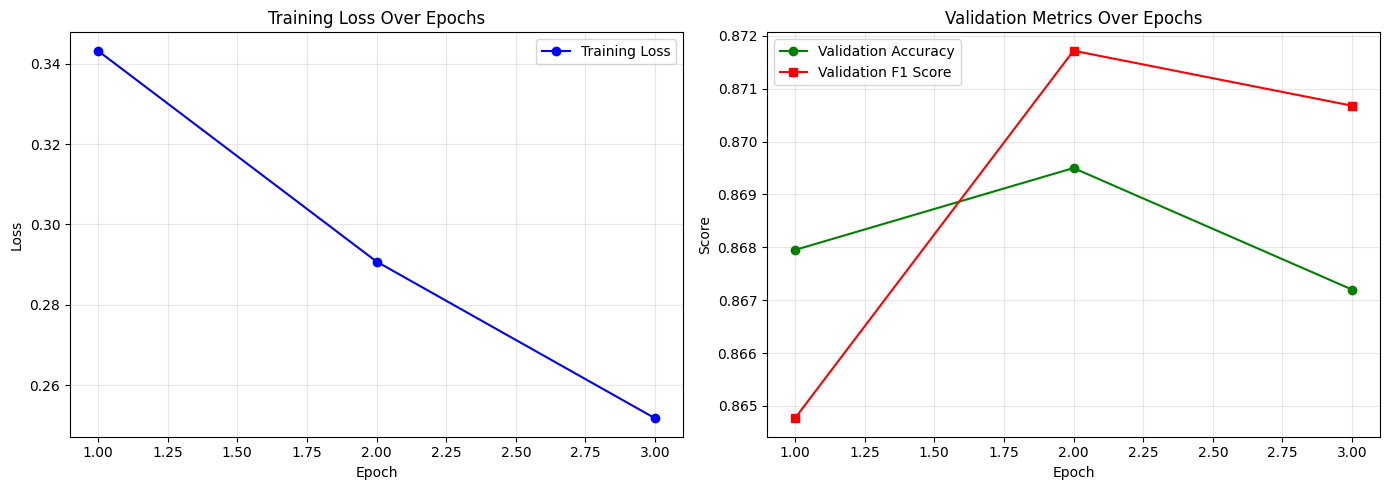


📊 Learning Curve Analysis:
  Final Training Loss: 0.2517
  Final Validation Accuracy: 86.72%
  Final Validation F1: 0.8707


In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss
axes[0].plot(training_history['epochs'], training_history['train_loss'], 'b-o', label='Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Metrics
axes[1].plot(training_history['epochs'], training_history['val_accuracy'], 'g-o', label='Validation Accuracy')
axes[1].plot(training_history['epochs'], training_history['val_f1'], 'r-s', label='Validation F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Learning Curve Analysis:")
print(f"  Final Training Loss: {training_history['train_loss'][-1]:.4f}")
print(f"  Final Validation Accuracy: {training_history['val_accuracy'][-1]*100:.2f}%")
print(f"  Final Validation F1: {training_history['val_f1'][-1]:.4f}")

# Check for overfitting
if training_history['train_loss'][-1] < training_history['train_loss'][0] * 0.3:
    if training_history['val_accuracy'][-1] < training_history['val_accuracy'][0]:
        print("  ⚠️  Warning: Possible overfitting detected (train loss decreasing but val accuracy not improving)")

### 4.7 Confusion Matrix on Test Set

Generate predictions on the test set and visualize the confusion matrix to understand model performance across classes.

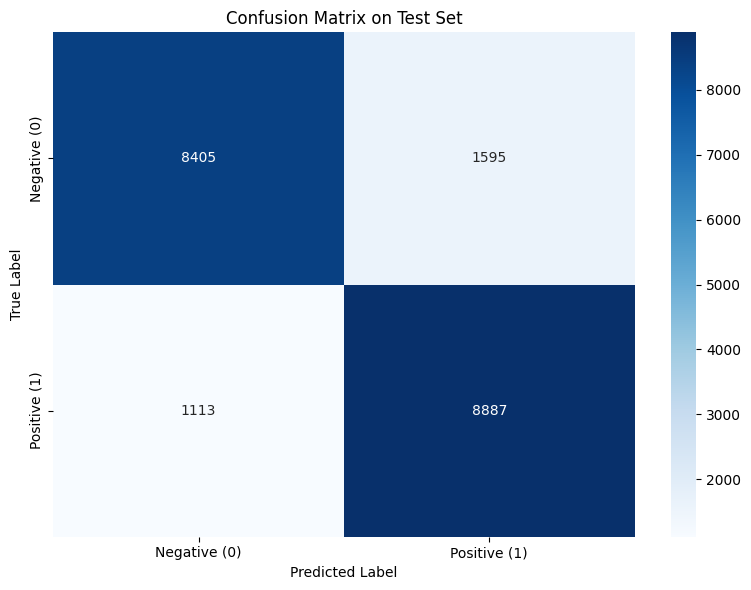


📊 Test Set Classification Report:
              precision    recall  f1-score   support

    Negative     0.8831    0.8405    0.8613     10000
    Positive     0.8478    0.8887    0.8678     10000

    accuracy                         0.8646     20000
   macro avg     0.8654    0.8646    0.8645     20000
weighted avg     0.8654    0.8646    0.8645     20000


📈 Additional Metrics:
  True Negatives:  8,405
  False Positives: 1,595
  False Negatives: 1,113
  True Positives:  8,887

  Sensitivity (Positive Recall): 88.87%
  Specificity (Negative Recall): 84.05%
  Positive Precision: 84.78%
  Negative Precision: 88.31%


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Generate predictions on test set
final_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        
        outputs = final_model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        
        all_preds.extend(predictions)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative (0)', 'Positive (1)'],
            yticklabels=['Negative (0)', 'Positive (1)'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\n📊 Test Set Classification Report:")
print(classification_report(all_labels, all_preds, 
                          target_names=['Negative', 'Positive'], 
                          digits=4))

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for positive class
specificity = tn / (tn + fp)  # Recall for negative class
precision_pos = tp / (tp + fp)
precision_neg = tn / (tn + fn)

print("\n📈 Additional Metrics:")
print(f"  True Negatives:  {tn:,}")
print(f"  False Positives: {fp:,}")
print(f"  False Negatives: {fn:,}")
print(f"  True Positives:  {tp:,}")
print(f"\n  Sensitivity (Positive Recall): {sensitivity*100:.2f}%")
print(f"  Specificity (Negative Recall): {specificity*100:.2f}%")
print(f"  Positive Precision: {precision_pos*100:.2f}%")
print(f"  Negative Precision: {precision_neg*100:.2f}%")